# Procesamiento de lenguaje natural
## Desafío 2


### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará el libro de Issac Asimov la trilogía de "Fundación".

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaré la trilogía de la obra de Issac Asimov "Fundación" condensada en un solo volumen y en formato texto, y en español.

In [2]:
# Directorio de los dataset de libros
os.listdir("./libros_dataset/")

['Fundacion.txt']

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('libros_dataset/Fundacion.txt', sep='/n', header=None)
df.head()

/tmp/ipykernel_216200/1480457263.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('libros_dataset/Fundacion.txt', sep='/n', header=None)


,0
0,TRILOGÍA DE LA FUNDACION
1,FUNDACIÓN
2,FUNDACIÓN E IMPERIO
3,SEGUNDA FUNDACIÓN
4,Reunión en un solo volumen de las tres novelas...


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 26966


### 1 - Preprocesamiento

In [5]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

2024-05-15 19:51:26.439029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 19:51:26.533931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 19:51:26.934887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jorge/miniconda3/envs/tensorflow/lib/:/home/jorge/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorrt/
2024-05-15 19:51:26.934956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [6]:
# Demos un vistazo
sentence_tokens[:2]

[['trilogía', 'de', 'la', 'fundacion'], ['fundación']]

### 2 - Crear los vectores (word2vec)

In [7]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [8]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=3,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=12,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [9]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [10]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 26966


In [11]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4351


### 3 - Entrenar embeddings

In [12]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=50,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 165977.796875
Loss after epoch 1: 132255.078125
Loss after epoch 2: 129650.5625
Loss after epoch 3: 125749.4375
Loss after epoch 4: 124449.75
Loss after epoch 5: 123694.875
Loss after epoch 6: 118778.375
Loss after epoch 7: 117571.0625
Loss after epoch 8: 108173.8125
Loss after epoch 9: 103845.5
Loss after epoch 10: 104243.5
Loss after epoch 11: 104124.0
Loss after epoch 12: 103169.25
Loss after epoch 13: 98561.0
Loss after epoch 14: 100296.5
Loss after epoch 15: 98142.875
Loss after epoch 16: 97929.25
Loss after epoch 17: 96228.375
Loss after epoch 18: 91784.0
Loss after epoch 19: 89619.75
Loss after epoch 20: 87736.0
Loss after epoch 21: 87183.25
Loss after epoch 22: 87904.5
Loss after epoch 23: 86394.0
Loss after epoch 24: 83824.5
Loss after epoch 25: 83307.25
Loss after epoch 26: 81071.5
Loss after epoch 27: 83980.5
Loss after epoch 28: 80146.0
Loss after epoch 29: 83853.0
Loss after epoch 30: 82599.5
Loss after epoch 31: 81100.0
Loss after epoch 32: 81935.75
Lo

(6656655, 10737500)

### 4 - Ensayar

Ensayare el modelo usando las siguientes palabras:

- Imperio.
- Seldon.
- Gaal
- Fundación.
- Psicohistoria.
- Enciclopedia.
- Mulo.
- Términus.
- Imperial.
- Trántor

### Similitudes

Mostraré las 5 palabras mas similes.

In [13]:
# Palabras que MÁS se relacionan con "Imperio":
w2v_model.wv.most_similar(positive=["imperio"], topn=5)


[('existido', 0.4030727446079254),
 ('galáctico', 0.3983217775821686),
 ('humanidad', 0.39571309089660645),
 ('excesivamente', 0.39510849118232727),
 ('comenzado', 0.37580254673957825)]

In [14]:
# Palabras que MÁS se relacionan con "Seldon":
w2v_model.wv.most_similar(positive=["seldon"], topn=5)

[('hari', 0.5577684044837952),
 ('8', 0.4948751628398895),
 ('dornick', 0.46323680877685547),
 ('inminente', 0.4187394678592682),
 ('preguntarle', 0.41489264369010925)]

In [15]:
# Palabras que MÁS se relacionan con "Gaal":
w2v_model.wv.most_similar(positive=["gaal"], topn=5)

[('dornick', 0.4184357821941376),
 ('aguardó', 0.38302549719810486),
 ('deslizó', 0.37936899065971375),
 ('—riose', 0.37477919459342957),
 ('tiró', 0.37447389960289)]

In [16]:
# Palabras que MÁS se relacionan con "Fundación":
w2v_model.wv.most_similar(positive=["fundación"], topn=5)

[('segunda', 0.48787885904312134),
 ('isaac', 0.41141343116760254),
 ('actualmente', 0.3859802186489105),
 ('convencido', 0.3688279688358307),
 ('magnitud', 0.36507895588874817)]

In [17]:
# Palabras que MÁS se relacionan con "Psicohistoria":
w2v_model.wv.most_similar(positive=["psicohistoria"], topn=5)

[('distintas', 0.485897034406662),
 ('previó', 0.4676920473575592),
 ('predice', 0.44595617055892944),
 ('leyes', 0.43519508838653564),
 ('predecir', 0.43483325839042664)]

In [18]:
# Palabras que MÁS se relacionan con "Enciclopedia":
w2v_model.wv.most_similar(positive=["enciclopedia"], topn=5)

[('proceden', 0.5330999493598938),
 ('espiral', 0.48262232542037964),
 ('edición', 0.47405505180358887),
 ('hagdin', 0.44100964069366455),
 ('7', 0.4290894567966461)]

In [19]:
# Palabras que MÁS se relacionan con "Mulo":
w2v_model.wv.most_similar(positive=["mulo"], topn=5)

[('mutación', 0.3538320064544678),
 ('paradero', 0.34652140736579895),
 ('—n', 0.3362007439136505),
 ('definitiva', 0.3358514606952667),
 ('—todavía', 0.335481733083725)]

In [20]:
# Palabras que MÁS se relacionan con "Términus":
w2v_model.wv.most_similar(positive=["términus"], topn=5)

[('llegará', 0.37079164385795593),
 ('periódicos', 0.35099247097969055),
 ('indefensos', 0.35057616233825684),
 ('casos', 0.34759628772735596),
 ('establecida', 0.3474271297454834)]

In [21]:
# Palabras que MÁS se relacionan con "Imperial":
w2v_model.wv.most_similar(positive=["imperial"], topn=5)

[('terrenos', 0.4770962595939636),
 ('majestad', 0.445779025554657),
 ('biblioteca', 0.43380528688430786),
 ('etiqueta', 0.4203985631465912),
 ('excesivamente', 0.4068523049354553)]

In [22]:
# Palabras que MÁS se relacionan con "Trántor":
w2v_model.wv.most_similar(positive=["trántor"], topn=5)

[('santanni', 0.4274616241455078),
 ('agrícola', 0.3548995554447174),
 ('setenta', 0.34900394082069397),
 ('creí', 0.34755203127861023),
 ('muerto', 0.3404932916164398)]

#### Conclusiones palabras similares

- Imperio: Las palabras relacionadas aparentemente parecen estar vinculadas con conceptos de grandeza y destino, lo cual tiene sentido en el contexto de un imperio galáctico.
- Seldon: Se puede ver que las palabras asociadas están directamente relacionadas con el personaje Hari Seldon.
- Gaal: Similar a "Seldon", las palabras asociadas incluyen otro personaje, "Dornick", y otros términos que estan relacionados con eventos del libro.
- Fundación: Las palabras asociadas se encuentran relacionados con la institución central de la serie, como "segunda", quizás refiriéndose a la Segunda Fundación y "protección" haciendo referencia a guardar el legado humano lejos del imperio.
- Psicohistoria: Los términos relacionados reflejan aspectos de la psicohistoria, la ciencia ficticia central en la serie de la Fundación que se utiliza para predecir el futuro en términos estadísticos (Algo como los que sería hoy en día la Inteligencia Artificial).
- Enciclopedia: Las palabras asociadas parecen tener relación con la creación y distribución de conocimiento, lo cual es un tema clave en el libro.
- Mulo: El término podrían reflejar aspectos del personaje del Mulo en el libro, el cual es un mutante con habilidades extraordinarias y maligno.
- Términus: Las palabras asociados parecen estar relacionados con la ubicación de la Fundación y eventos clave en la historia.
- Imperial: Las palabras asociadas sugieren temas de gobierno y poder, lo cual es apropiado para algo relacionado con un gobierno imperial.
- Trántor: Las palabras asociadas parecen estar relacionadas con lugares y temas del imperio, ya que Trántor es la capital del Imperio Galáctico en el libro.

### Diferencias

Mostraré las 5 palabras mas diferentes.

In [23]:
# Palabras que MENOS se relacionan con "Imperio":
w2v_model.wv.most_similar(negative=["imperio"], topn=5)

[('observó', 0.1053815633058548),
 ('aceptó', 0.03230023756623268),
 ('siento', 0.027397502213716507),
 ('delante', 0.023887019604444504),
 ('chica', 0.022473230957984924)]

In [24]:
# Palabras que MENOS se relacionan con "Seldon":
w2v_model.wv.most_similar(negative=["seldon"], topn=5)

[('atómicos', 0.06751912832260132),
 ('dando', 0.049489155411720276),
 ('vestido', 0.0296217929571867),
 ('hablaba', 0.016470400616526604),
 ('veía', 0.014132052659988403)]

In [25]:
# Palabras que MENOS se relacionan con "Gaal":
w2v_model.wv.most_similar(negative=["gaal"], topn=5)

[('casa', 0.0618123859167099),
 ('además', 0.04903120920062065),
 ('atómicos', 0.037599802017211914),
 ('flota', 0.034557316452264786),
 ('—es', 0.02421911060810089)]

In [26]:
# Palabras que MENOS se relacionan con "Fundación":
w2v_model.wv.most_similar(negative=["fundación"], topn=5)

[('apareció', 0.03505517169833183),
 ('delgado', 0.025930674746632576),
 ('brillo', 0.022172292694449425),
 ('saltar', 0.01487539429217577),
 ('receptor', 0.014838745817542076)]

In [27]:
# Palabras que MENOS se relacionan con "Psicohistoria":
w2v_model.wv.most_similar(negative=["psicohistoria"], topn=5)

[('muchacho', 0.08672347664833069),
 ('esperaba', 0.03207551687955856),
 ('recibió', 0.028722310438752174),
 ('esperando', 0.014120209030807018),
 ('salido', 0.012247462756931782)]

In [28]:
# Palabras que MENOS se relacionan con "Enciclopedia":
w2v_model.wv.most_similar(negative=["enciclopedia"], topn=5)

[('salto', 0.03480517119169235),
 ('magnífico', 0.030895791947841644),
 ('segura', 0.022153733298182487),
 ('cierta', 0.01662737876176834),
 ('murmullo', 0.013862372376024723)]

In [29]:
# Palabras que MENOS se relacionan con "Mulo":
w2v_model.wv.most_similar(negative=["mulo"], topn=5)

[('compañía', 0.04644446074962616),
 ('placer', 0.045107390731573105),
 ('lista', 0.036335330456495285),
 ('serán', 0.033704739063978195),
 ('dando', 0.025131268426775932)]

In [30]:
# Palabras que MENOS se relacionan con "Términus":
w2v_model.wv.most_similar(negative=["términus"], topn=5)

[('lentamente', 0.055616457015275955),
 ('falta', 0.05363558605313301),
 ('exclamó', 0.05207645520567894),
 ('débil', 0.03584456071257591),
 ('sangre', 0.03376036509871483)]

In [31]:
# Palabras que MENOS se relacionan con "Imperial":
w2v_model.wv.most_similar(negative=["imperial"], topn=5)

[('reflexionó', 0.06968114525079727),
 ('repitió', 0.043838948011398315),
 ('preguntó', 0.03595082834362984),
 ('—una', 0.03541895002126694),
 ('murmuró', 0.029237933456897736)]

In [32]:
# Palabras que MENOS se relacionan con "Trántor":
w2v_model.wv.most_similar(negative=["trántor"], topn=5)

[('torpe', 0.05513375625014305),
 ('—fue', 0.04359928518533707),
 ('tienen', 0.042713794857263565),
 ('ansiedad', 0.040310606360435486),
 ('permitió', 0.03335445374250412)]

#### Conclusiones palabras diferentes

- Las palabras menos similares parecen ser bastante genéricas y no aparentemente no tienen una relación temática con las palabras de interés. Por lo que se puede decir es que el modelo ha aprendido a distinguir entre palabras que son centralmente importantes para los temas y tramas del libro y aquellas que no lo son.

### 5 - Visualizar agrupación de vectores

In [33]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [34]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
#fig.show(renderer="colab") # esto para plotly en colab
fig.show()

In [35]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
#fig.show(renderer="colab") # esto para plotly en colab
fig.show() # esto para plotly en colab

In [36]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

### 6 - Visualizar agrupación de vectores en baja dimensionalidad

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def reducir_y_graficar(model, key_word, num_similar=5, similares=True):
    if similares:
        similar_words = [word for word, _ in model.wv.most_similar(positive=[key_word], topn=num_similar)]
        string_similar = 'más'
    else:
        similar_words = [word for word, _ in model.wv.most_similar(negative=[key_word], topn=num_similar)]
        string_similar = 'menos'

    words = [key_word] + similar_words
    word_vectors = np.array([model.wv[word] for word in words])

    # Ajusto la perplexity para un número pequeño de muestras (sino da error)
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(5, len(words) - 1))
    vectors_2d = tsne.fit_transform(word_vectors)

    # Creo un gráfico
    plt.figure(figsize=(10, 8))
    # Dibujo la palabra clave en rojo
    plt.scatter(vectors_2d[0, 0], vectors_2d[0, 1], c='red', label=key_word, s=100)  # Aumentar tamaño para destacar
    # Dibujo los vecinos en azul
    plt.scatter(vectors_2d[1:, 0], vectors_2d[1:, 1], c='blue', label='Vecinos')
    
    # Dibujo líneas entre la palabra clave y cada vecino
    # Queda mas claro si se dibujan líneas y mas vistoso si se dibujan líneas semi-transparentes
    for i in range(1, len(vectors_2d)):
        plt.plot([vectors_2d[0, 0], vectors_2d[i, 0]], [vectors_2d[0, 1], vectors_2d[i, 1]], 'k-', alpha=0.3)  # Líneas negras, semi-transparentes

    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))
    plt.title(f'Visualización de \'{key_word}\' y sus 5 embeddings {string_similar} similares más cercanos')
    plt.legend()
    plt.show()


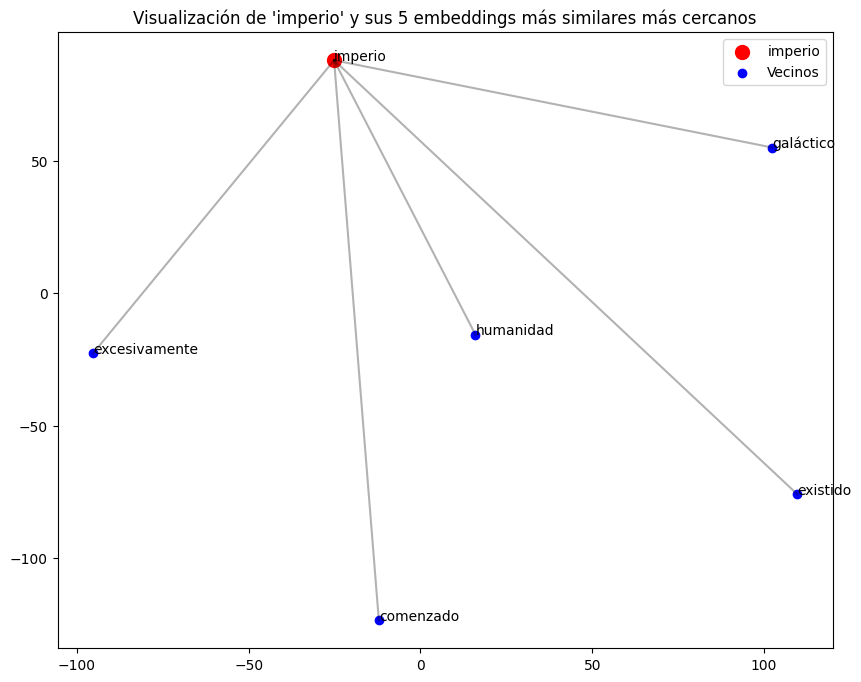

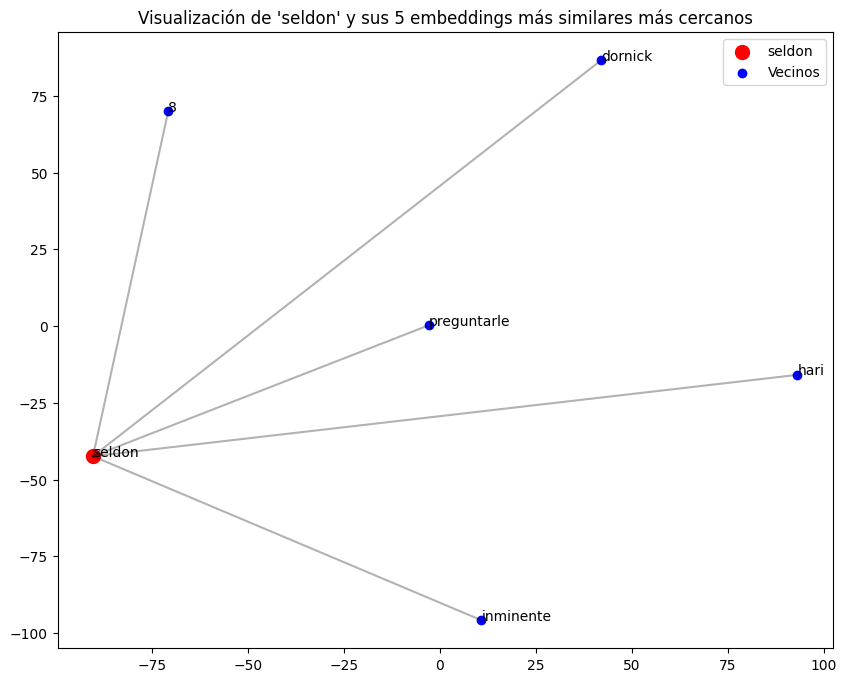

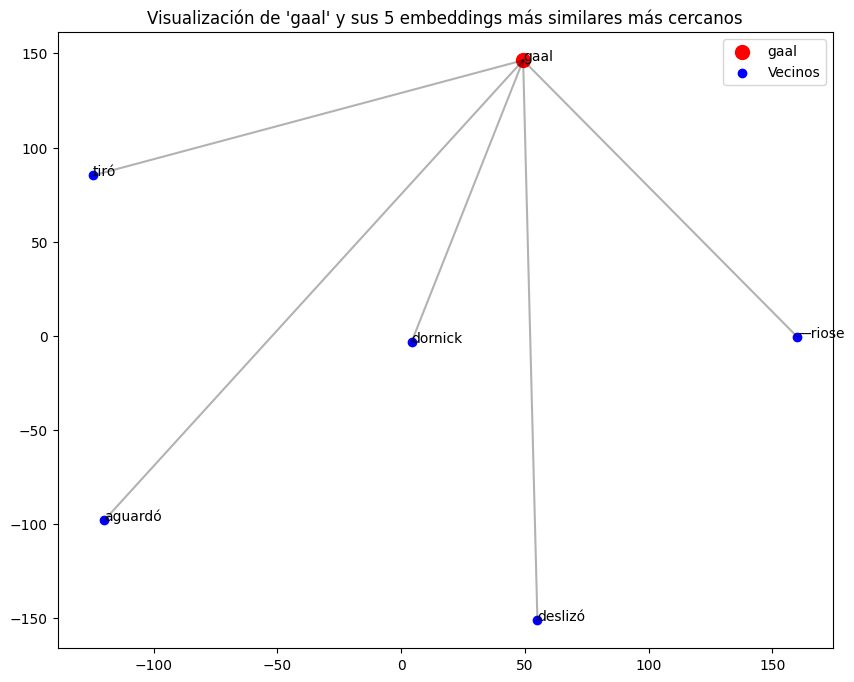

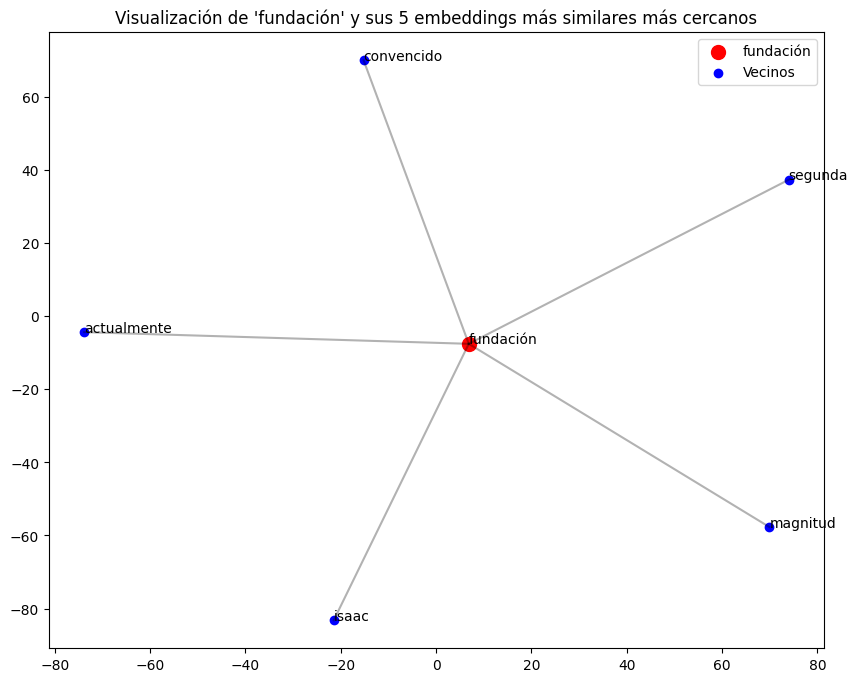

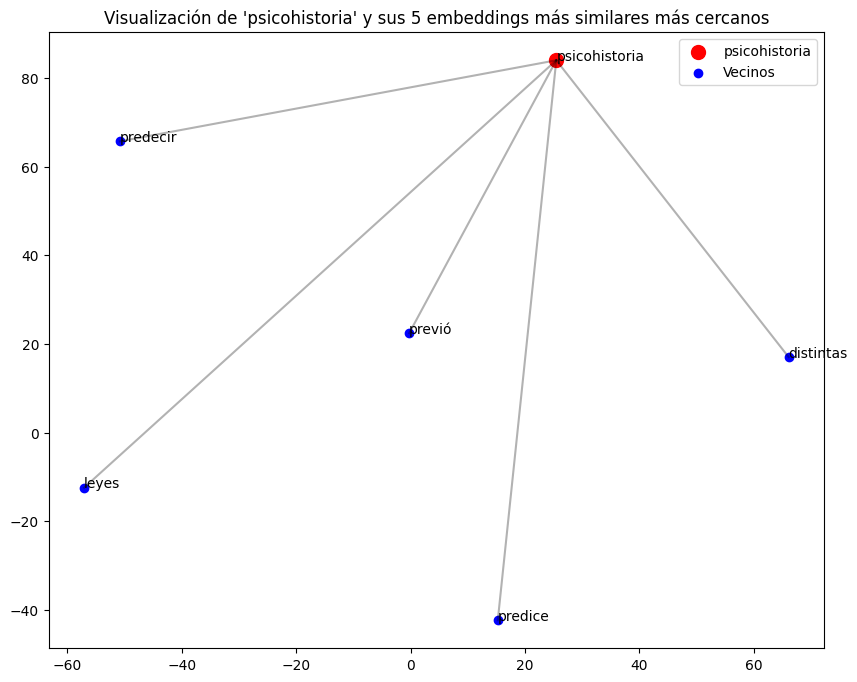

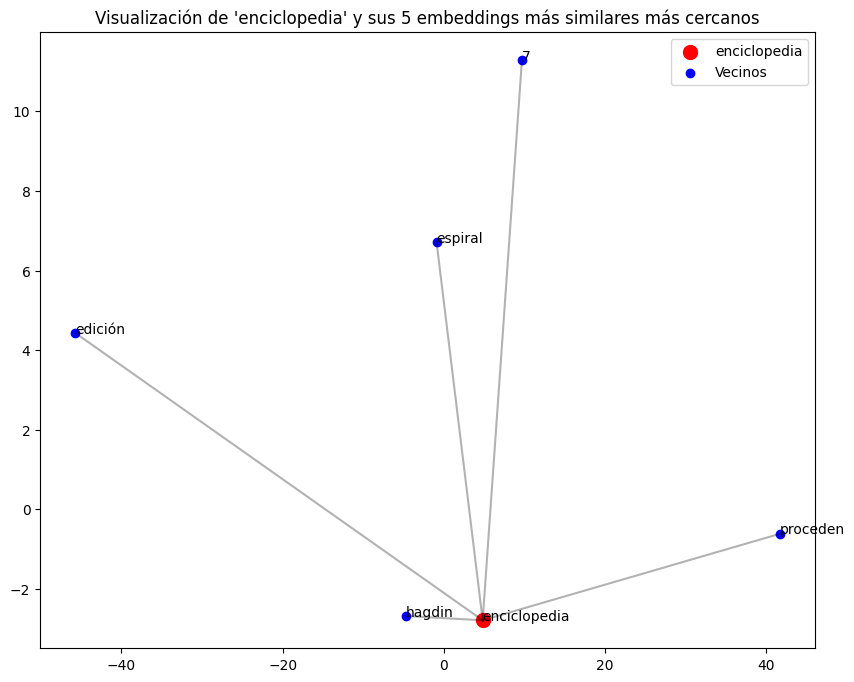

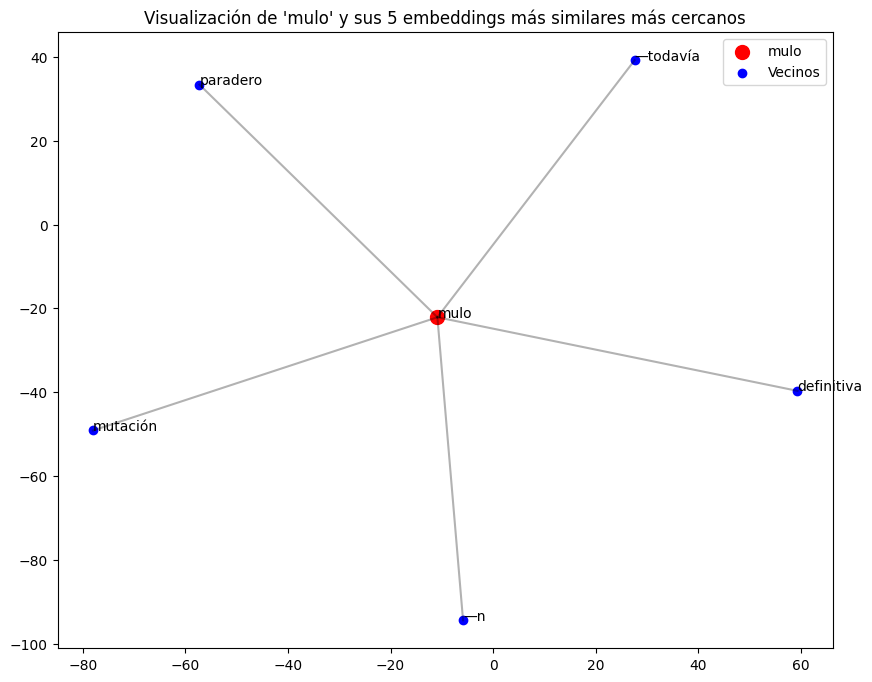

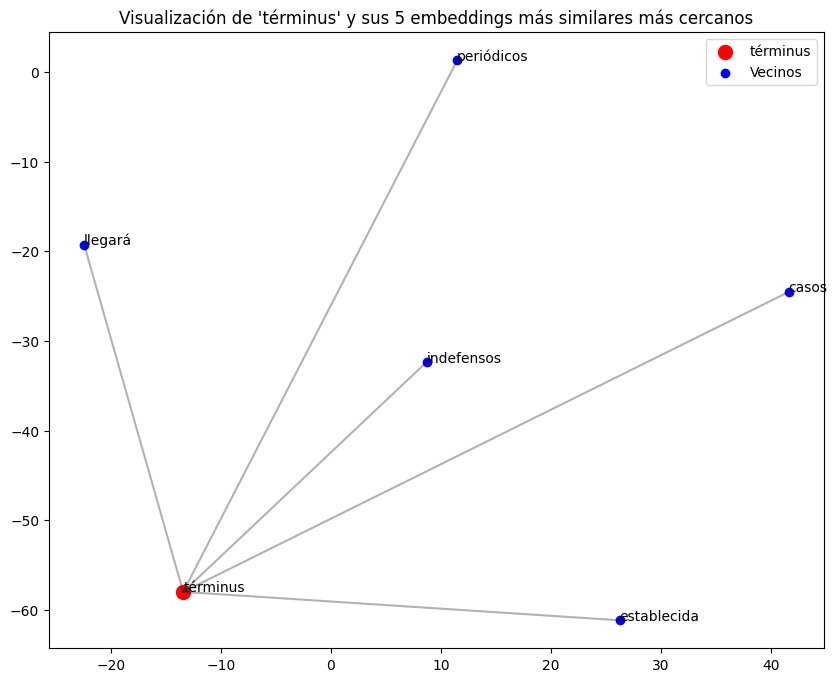

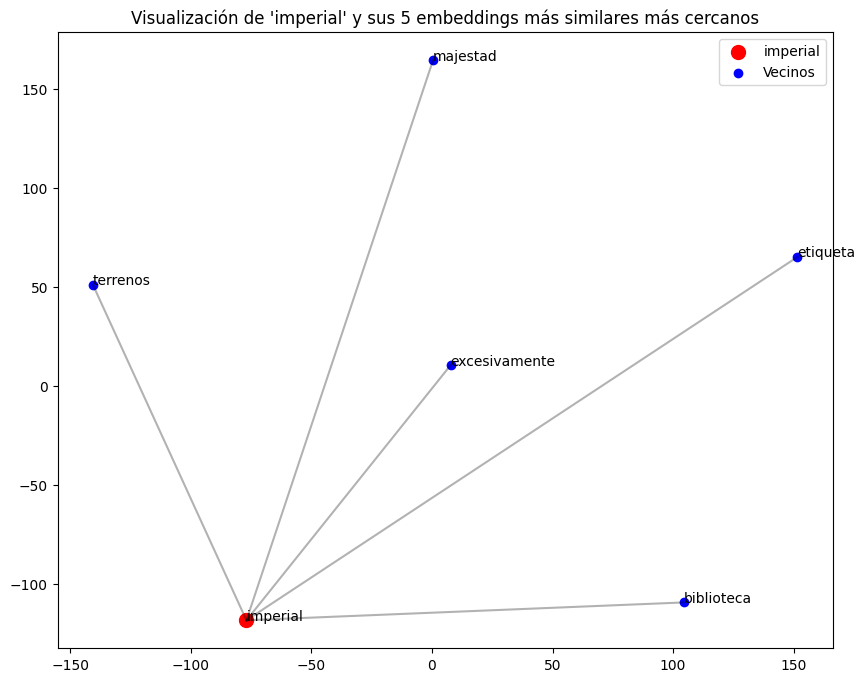

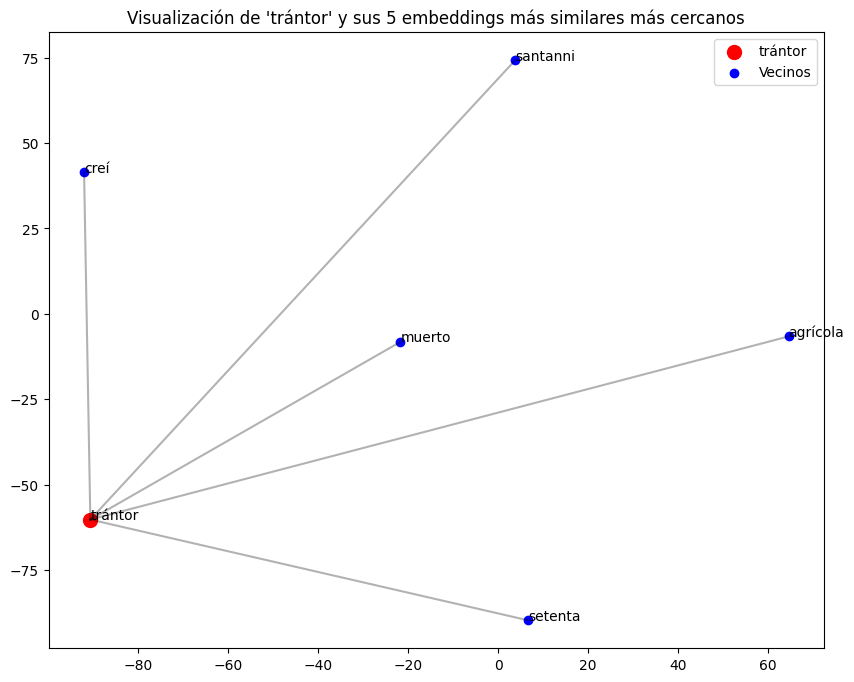

In [38]:
# Grafico las siguientes palabras y sus 5 embdeddings más similares más cercanos
reducir_y_graficar(w2v_model, 'imperio', similares=True)
reducir_y_graficar(w2v_model, 'seldon', similares=True)
reducir_y_graficar(w2v_model, 'gaal', similares=True)
reducir_y_graficar(w2v_model, 'fundación', similares=True)
reducir_y_graficar(w2v_model, 'psicohistoria', similares=True)
reducir_y_graficar(w2v_model, 'enciclopedia', similares=True)
reducir_y_graficar(w2v_model, 'mulo', similares=True)
reducir_y_graficar(w2v_model, 'términus', similares=True)
reducir_y_graficar(w2v_model, 'imperial', similares=True)
reducir_y_graficar(w2v_model, 'trántor', similares=True)

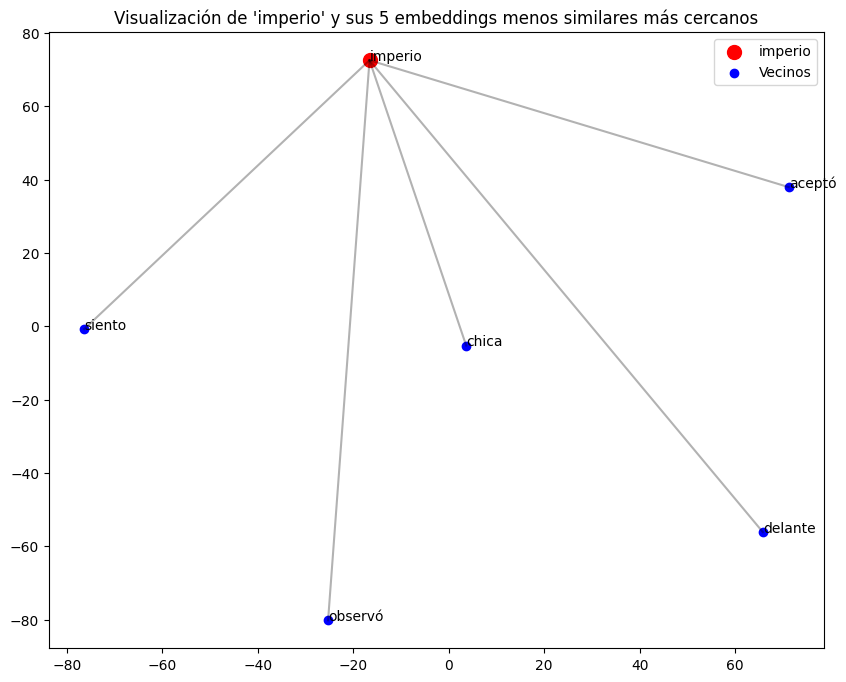

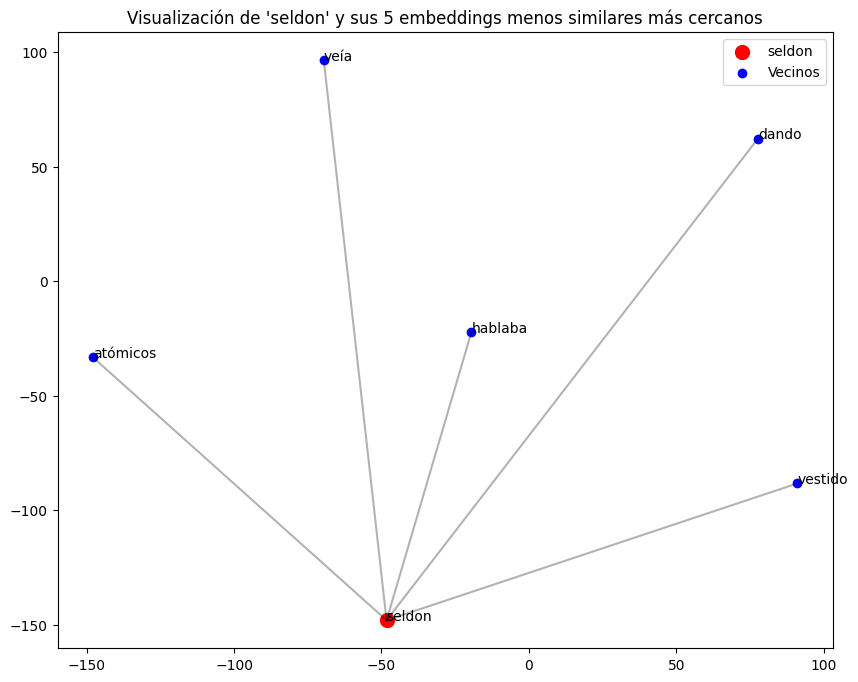

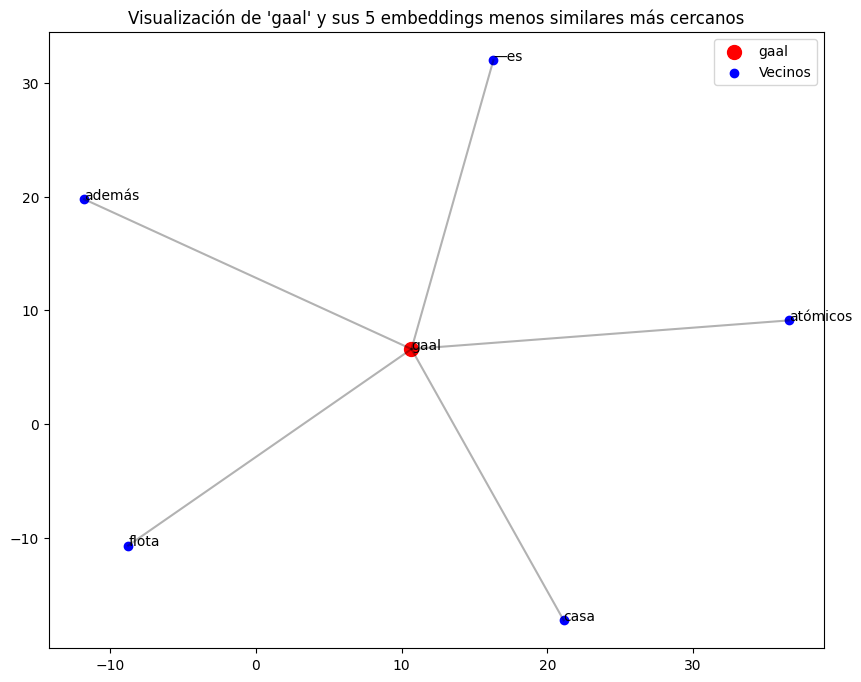

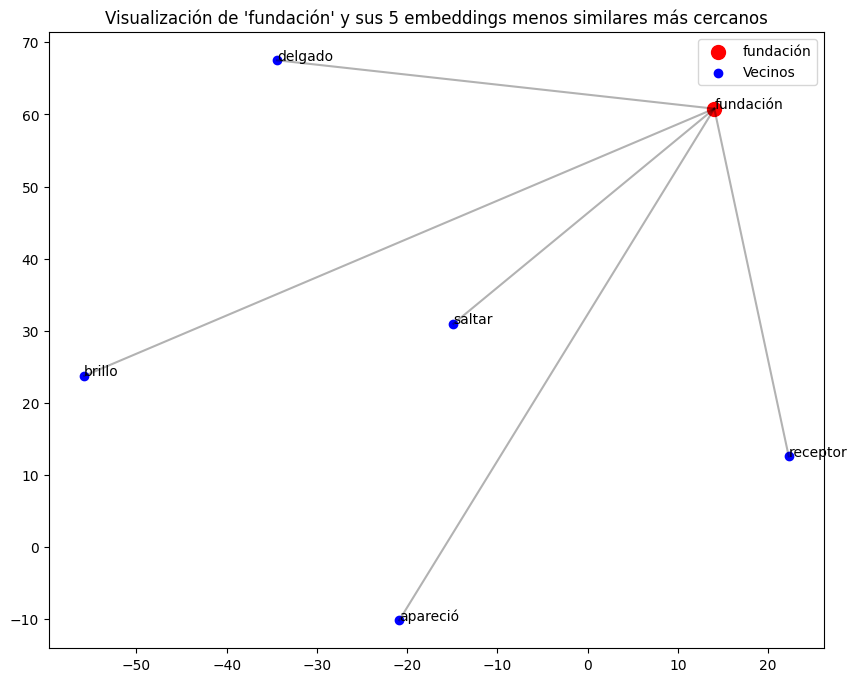

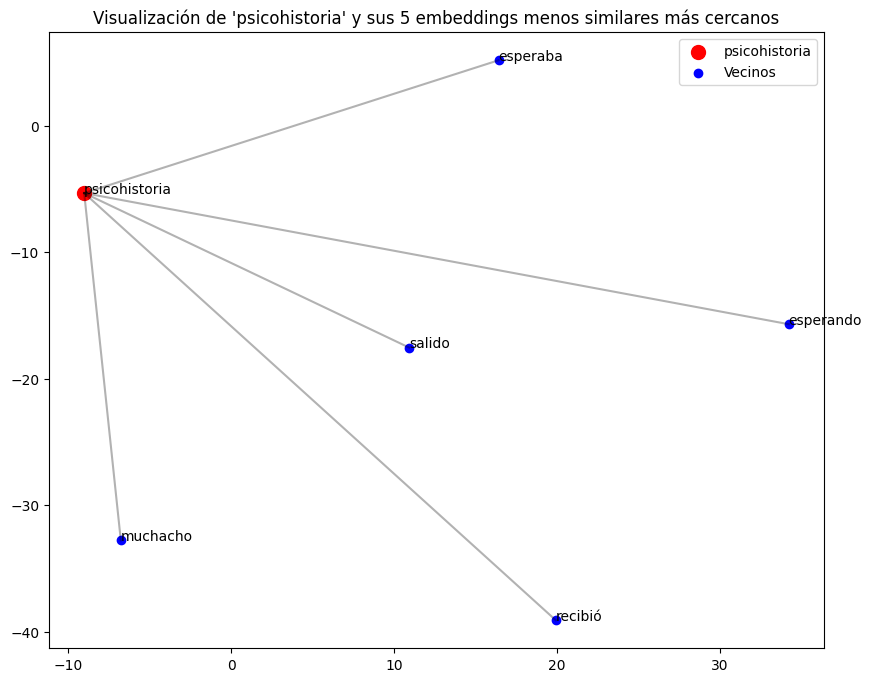

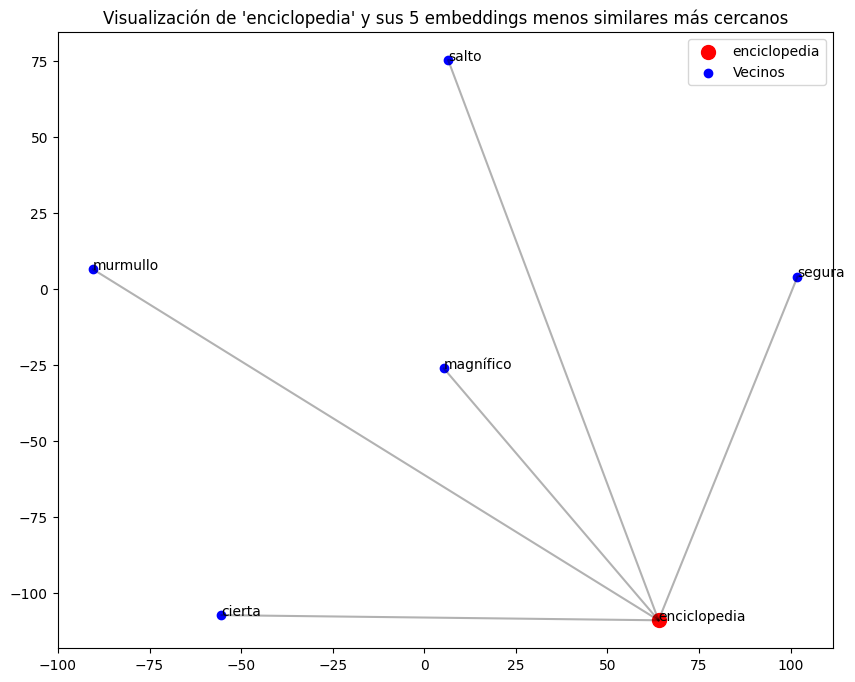

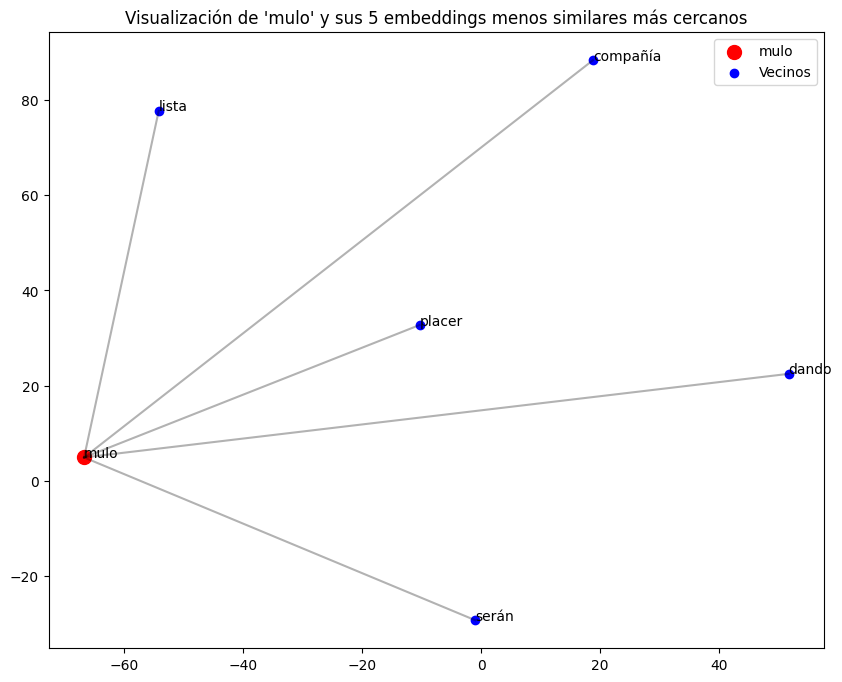

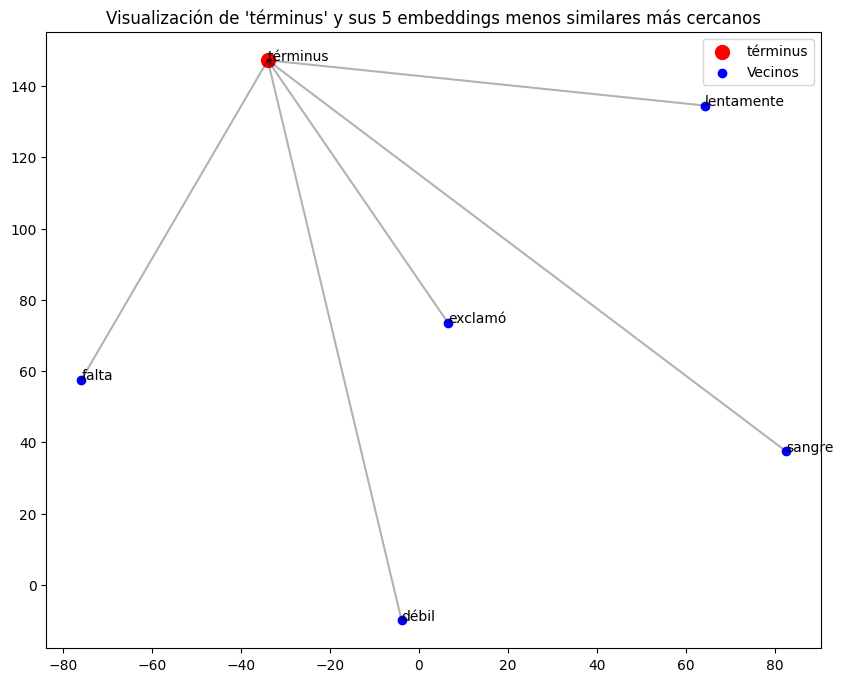

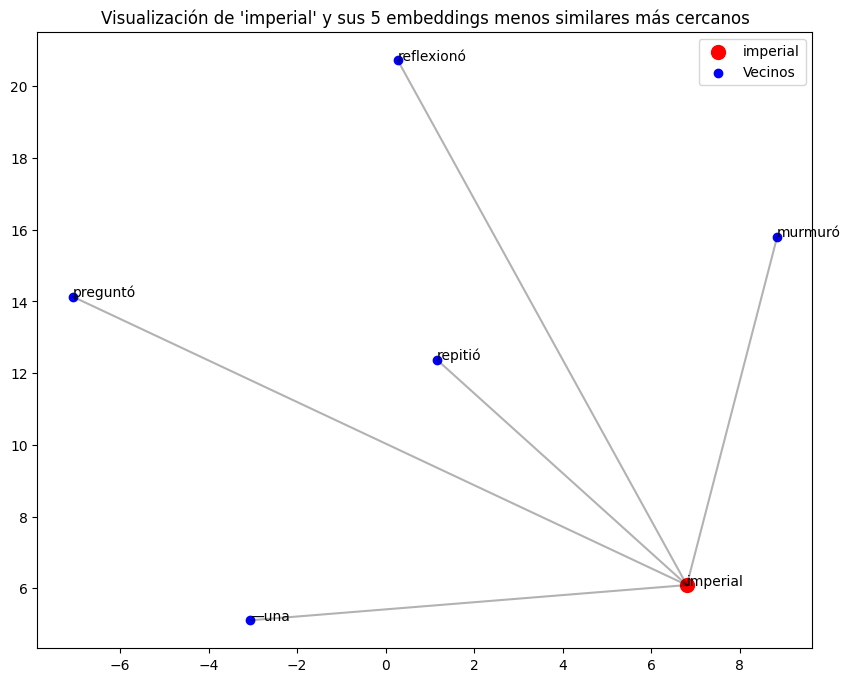

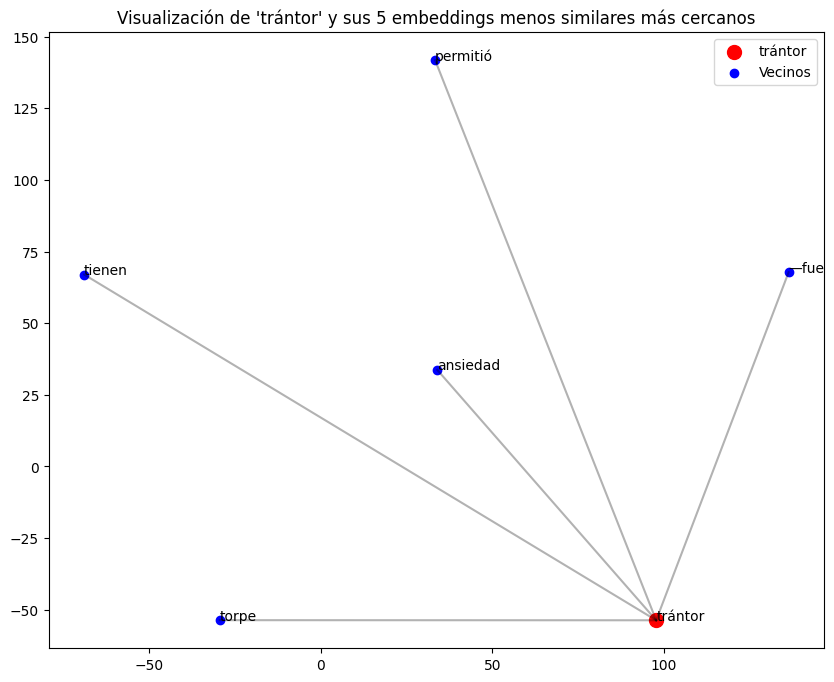

In [39]:
# Grafico las siguientes palabras y sus 5 embdeddings menos similares más cercanos
reducir_y_graficar(w2v_model, 'imperio', similares=False)
reducir_y_graficar(w2v_model, 'seldon', similares=False)
reducir_y_graficar(w2v_model, 'gaal', similares=False)
reducir_y_graficar(w2v_model, 'fundación', similares=False)
reducir_y_graficar(w2v_model, 'psicohistoria', similares=False)
reducir_y_graficar(w2v_model, 'enciclopedia', similares=False)
reducir_y_graficar(w2v_model, 'mulo', similares=False)
reducir_y_graficar(w2v_model, 'términus', similares=False)
reducir_y_graficar(w2v_model, 'imperial', similares=False)
reducir_y_graficar(w2v_model, 'trántor', similares=False)

### 6 - Conclusión

> Dado el rendimiento puede verse que el modelo parece capturar bien las asociaciones temáticas y narrativas del libro "Fundación". Las palabras más similares reflejan relaciones lógicas dentro del universo del libro, mostrando que los embeddings pueden capturar el contexto y las relaciones semánticas dentro de un texto específico. Por otro lado, las palabras menos similares no parecen tener una conexión directa, lo cual es esperado ya que estas palabras probablemente no comparten contexto o relevancia en el texto con los términos seleccionados.

> Las conclusiones extraídas dependieron de  la forma en que se realizo el preprocesamiento, del tamaño y diversidad del corpus, y de la configuración del modelo Word2Vec. Ya que sería optimo reorganizar el texto y preprocesarlo para que tome como documento una oración completa y que un punto sea el final del docuemtno. El texto empleado no esta organizado de esta manera. 

> Las interpretaciones están limitadas a las relaciones aprendidas exclusivamente dentro del texto de "Fundación" y no necesariamente reflejan el uso en el lenguaje común.